# Captain's Log
The Captain's Log is a transcription machine.

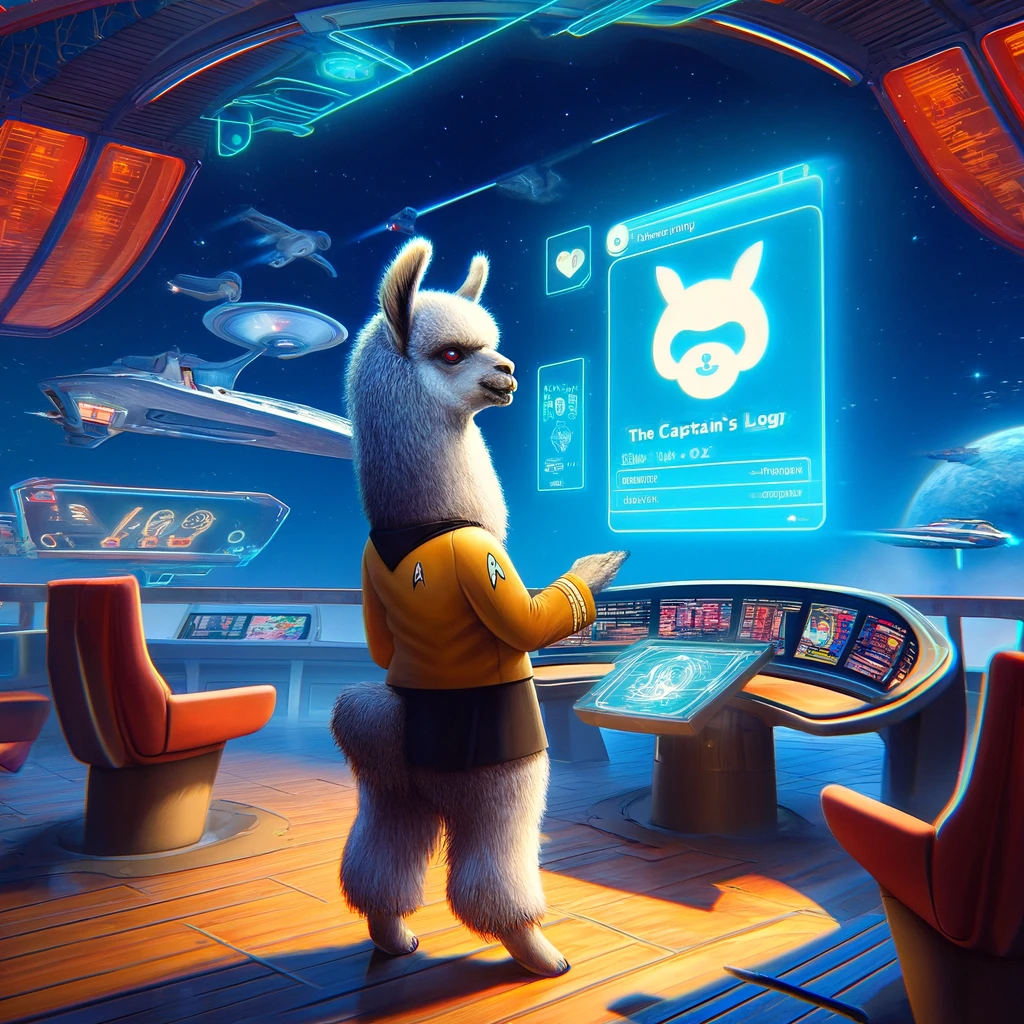

## Initialise
Uncomment to install the required packages.
Make sure you have supported models at the Whisper and Ollama API endpoints.

In [1]:
#!pip install pyaudio requests watchdog pyttsx3 torchaudio omegaconf simpleaudio

In [2]:
import os
import logger_tool as logger


app = 'captain'
log_path = "logs"
logger_name = 'logger_tool'
log_level = 'APP'

logging = logger.get_logger(name=logger_name, log_level=log_level, log_path=log_path, log_file=app)
logging.app(f"Logger {logger_name} has been instantiated with log level: {log_level}")

2024-04-21 23:30:16,862 APP       : logger_tool > app >>> Logger logger_tool has been instantiated with log level: APP


In [3]:
import shutil
import re
import csv
import glob
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
import pyaudio
import audioop
import requests
import threading
import time
import json
from datetime import datetime, timedelta
from queue import Queue, Empty
import concurrent.futures
from threading import Thread
import numpy as np
import string
import torchaudio
from torchaudio.transforms import Resample
import torch
import simpleaudio as sa


C:\Users\tidym\AppData\Local\Temp\ipykernel_4468\3077895288.py:8: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop


## Setup
Set some variables such as names of user/AI, and the path to the data. Tex/log/file delimiters are also defined here but are silly and will be removed in the future.

In [4]:
user_name_short = 'KCAR'
ai_name_short = 'SHIP'

today_date = datetime.now().strftime("%Y-%m-%d")
file_delimiter = '_'
log_delimiter = '>>>>' # might not be needed here. silly anyway.

text_log_path = os.path.join(log_path, "text_logs", today_date)
audio_log_path = os.path.join(log_path, "audio_logs", today_date)
os.makedirs(text_log_path, exist_ok=True)
os.makedirs(os.path.join(audio_log_path, user_name_short), exist_ok=True)
os.makedirs(os.path.join(audio_log_path, ai_name_short), exist_ok=True)

now_time = datetime.now().strftime("%H-%M-%S")
runtime_log_file_name = os.path.join(text_log_path, f"{user_name_short}{file_delimiter}{now_time}.log")

Set API endpoints for the models

In [5]:
# Whisper transcription model URL
transcription_model_url = 'http://localhost:11437/translate'

# API URL for chat and generate using Ollama model
ollama_model_chat_url = 'http://localhost:11434/api/chat'
ollama_model_generate_url = 'http://localhost:11434/api/generate'


Setup the TTS model (this is managed in-code)

In [6]:
# Set the voice for the speech synthesis
language = 'en'  # Example: 'en' for English
speaker = 'lj_16khz'  # Example: 'lj_16khz' for the English model
model, symbols, sample_rate, example_text, apply_tts = torch.hub.load(
    repo_or_dir='snakers4/silero-models',
    model='silero_tts',
    language=language,
    speaker=speaker
)

Using cache found in C:\Users\tidym/.cache\torch\hub\snakers4_silero-models_master


## App logic
The rest of the code handles the logic for the app. This is far from a suitable 'app' in its current form but handles the following:
- A main app logging tool which is available throughout the code. Log entries can be created by using logging.info('info log message'), logging.debug('debug log message') etc.
- File monitors that monitor the main app log and downstream logs for changes and call actions (this logic is buggy and highly unsuitable for what it is currently doing - this logic will be largely removed and replaced)
- Audio device handlers for recording audio. The current logic records only when audio is present and above a threshold.
- Transcription of user audio is handled by a whisper model hosted at a local API endpoint. Simple error handling of unintentional transcriptions and audio snippets is implemented.
- Successful transcriptions (user utterances) are first parsed and ingested by the ollama model to ascertain the intent of the user utterance. This is managed by instructing the ollama model to determine whether the utterance of of a fixed set of types (currently), e.g. question, statement, command etc and outputting a json structure that contains the result of the decision. This will be modified later to implement *routing* of user utterances.
- The utterance is then sent again to the ollama model but this time the model is instructed to respond in some way. A message history is also implemented here so that the conversation can approximate an AI agent with memory.
- Everything is logged in a messy and disorganised fashion!

In [7]:
def log_interaction(message, level='info', timestamp=None):
    """
    Creates a formatted text string to append to the app log. 

    Args:
        message (_type_): _description_. The message text from the interaction. Usually output by a model as a result of a user transcription or AI response.
        level (str, optional): _description_. Defaults to 'info'. This is the log level of the interaction. This is probably misnamed or redundant.
        timestamp (_type_, optional): _description_. Defaults to None but the current time is added anyway. TODO: Timestamps need better handling across async calls.
    """
    log_delimiter = '>>>>' # This is buggy and silly.
    if not timestamp:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    max_length = max(len("ERROR"), len("CAPTAIN'S LOG"), len("CHAT"), len("TRANSCRIBED"), len("RESPONSE"), len("REJECTED"), len("DEBUG")) # Keeps the app log neat and tidy
    
    # I haven't put any thought into this
    if level == 'error':
        logging.error(f"{timestamp} {'ERROR'.ljust(max_length)}: {message}")
    elif level == 'log':
        log_label = "CAPTAIN'S LOG"  # Move the string with the apostrophe outside the f-string
        logging.app(f"{log_label.ljust(max_length)}{log_delimiter}{timestamp}{log_delimiter}{message}")
    elif level == 'chat':
        chat_label = "CAPTAIN'S LOG"  # Move the string with the apostrophe outside the f-string
        logging.app(f"{chat_label.ljust(max_length)}{log_delimiter}{timestamp}{log_delimiter}{message}")
    elif level == 'transcribe':
        logging.chat(f"{timestamp} {'TRANSCRIBED'.ljust(max_length)}: {message}")
    elif level == 'ollama':
        logging.chat(f"{timestamp} {'RESPONSE'.ljust(max_length)}: {message}")
    elif level == 'reject':
        logging.debug(f"{timestamp} {'REJECTED'.ljust(max_length)}: {message}")
    elif level == 'debug':
        logging.debug(f"{timestamp} {'DEBUG'.ljust(max_length)}: {message}")

# TODO: The output indicates this might be broken
def split_text(text, max_length=140):
    """
    Splits text into chunks with a maximum length of `max_length`.
    This function tries to preserve whole words and sentences.
    """
    sentences = text.split('.')
    chunks = []
    current_chunk = ''

    for sentence in sentences:
        if len(current_chunk + sentence) < max_length:
            current_chunk += sentence + '.'
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence + '.'
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

# Move this and handle better. And optionally.
def play_audio(audio_file):
    wave_obj = sa.WaveObject.from_wave_file(audio_file)
    play_obj = wave_obj.play()
    play_obj.wait_done()


def process_user_utterance(transcription, timestamp=None, play=False):
    user_name = 'Captain KCAR'
    user_name_short = 'KCAR'
    log_delimiter = '>>>>'
    file_delimiter = '_'
    log = f'{user_name} uttered{log_delimiter}{transcription}'
    log_interaction(log, "log", timestamp)
    
    # Create speech. Probably do this optionally, if at all.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    chunks = split_text(transcription)
    combined_audio = None
    for chunk in chunks:
        chunk = chunk.strip()
        if chunk:
            if not chunk.endswith(('.', '?', '!')):
                chunk += '.'
            
            audio = apply_tts(
                texts=[chunk],
                model=model,
                sample_rate=sample_rate,
                symbols=symbols,
                device=device
            )
            if isinstance(audio, list):
                audio = torch.cat(audio, dim=0)
            if audio.ndim == 1:
                audio = audio.unsqueeze(0)
            
            if combined_audio is None:
                combined_audio = audio
            else:
                if combined_audio.ndim == 1:
                    combined_audio = combined_audio.unsqueeze(0)
                combined_audio = torch.cat((combined_audio, audio), dim=1)

    if combined_audio.ndim != 2:
        raise ValueError(f"Combined audio tensor is expected to be 2D, got {combined_audio.ndim}D tensor.")

    audio_filename = os.path.join(audio_log_path, user_name_short, f"utterance{file_delimiter}{timestamp.replace(':', '-')}.wav")
    print(f"Saving audio file: {audio_filename}")
    original_sample_rate = sample_rate
    target_sample_rate = 44100
    resample_transform = Resample(original_sample_rate, target_sample_rate)
    combined_audio_resampled = resample_transform(combined_audio)
    combined_audio_int16 = (combined_audio_resampled * 32767).to(torch.int16)
    torchaudio.save(audio_filename, combined_audio_int16, target_sample_rate)

    if play:
        while not os.path.exists(audio_filename):
            time.sleep(0.1)
        play_audio(audio_filename)
    return log

def process_ai_response(response, timestamp=None, play=True):
    ai_name='The Ship'
    ai_name_short='SHIP'
    log_delimiter='>>>>'
    file_delimiter='_'
    single_line_response = ' / '.join(response.splitlines())
    log = f'{ai_name} responded{log_delimiter}{single_line_response}'
    log_interaction(log, "log", timestamp)

    # Create speech. This should be moved to another function. Better options would be nice.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    chunks = split_text(response)
    combined_audio = None
    for chunk in chunks:
        chunk = chunk.strip()
        if chunk:
            if not chunk.endswith(('.', '?', '!')):
                chunk += '.'
            
            audio = apply_tts(
                texts=[chunk],
                model=model,
                sample_rate=sample_rate,
                symbols=symbols,
                device=device
            )
            if isinstance(audio, list):
                audio = torch.cat(audio, dim=0)
            if audio.ndim == 1:
                audio = audio.unsqueeze(0)

            if combined_audio is None:
                combined_audio = audio
            else:
                if combined_audio.ndim == 1:
                    combined_audio = combined_audio.unsqueeze(0)
                combined_audio = torch.cat((combined_audio, audio), dim=1)

    if combined_audio.ndim != 2:
        raise ValueError(f"Audio tensor is expected to be 2D, got {combined_audio.ndim}D tensor.")

    audio_filename = os.path.join(audio_log_path, ai_name_short, f"response{file_delimiter}{timestamp.replace(':', '-')}.wav")
    print(f"Saving audio to: {audio_filename}")
    original_sample_rate = sample_rate 
    target_sample_rate = 44100
    resample_transform = Resample(original_sample_rate, target_sample_rate)
    combined_audio_resampled = resample_transform(combined_audio)
    combined_audio_int16 = (combined_audio_resampled * 32767).to(torch.int16)
    torchaudio.save(audio_filename, combined_audio_int16, target_sample_rate)
    
    # We probably want to turn off the microphone while this audio is playing so as not to capture unwanted transcripts.
    if play:
        while not os.path.exists(audio_filename):
            time.sleep(0.1)
        print(f"Playing audio file: {audio_filename}")
        play_audio(audio_filename)

    return log

### Calling the LLM
Here we call the ollama API endpoint which should be hosting a suitable model. Tested with llama2 and llama3.

In [8]:
# Handle calls to ollama asynchronously
def send_to_ollama_async(prompt, callback):
    def task():
        response = send_to_ollama(prompt)
        if callback:
            callback(prompt, response)
    return Thread(target=task)

# This function posts a chat completion (i think) request to the ollama chat completion
def send_to_ollama(transcript_packet, previous_conversation):
    prompt, timestamp = transcript_packet
    try:
        if previous_conversation:
            print("Previous conversation exists: ", previous_conversation)
        messages = previous_conversation + [{"role": "user", "content": prompt}]
        payload = {
            "model": "llama3",
            "messages": previous_conversation + [{"role": "user", "content": prompt}],
            "stream": False  # Use streaming if needed
        }
        headers = {
            'Content-Type': 'application/json'
        }
        
        url = ollama_model_chat_url
        ollama_response = requests.post(url, headers=headers, json=payload)
        
        if ollama_response.status_code == 200:
            response_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            response_json = ollama_response.json()
            ai_content = response_json.get('message', {}).get('content', '')
            previous_conversation.append({"role": "assistant", "content": ai_content})
            return response_json, response_timestamp, previous_conversation
        else:
            raise ValueError(f"Received non-200 response: {ollama_response.status_code} - {ollama_response.text}")
    except requests.exceptions.RequestException as e:
        raise ValueError(f"An error occurred while sending request to Ollama: {e}")


In [9]:
# Manage the audio stream
class AudioManager:
    # Define the preferred input and output devices (change as needed)
    preferred_inputs = ["Headset (Galaxy Buds (3DCC))", "Microphone (USBAudio1.0)", "Microphone (Samson Meteor Mic)"]
    preferred_outputs = ["Headphones (Galaxy Buds (3DCC))", "Speakers (NVIDIA High Definition Audio)"]  # Add this if managing output devices programmatically in future
    min_silence_time = 5  # Minimum silence time in seconds before stopping recording
    min_recording_time = 3  # Minimum recording time in seconds
    max_chunk_duration = 30  # Maximum duration of audio chunk in seconds
    
    def __init__(self):
        self.device_number = 0  # Default input device number
        self._mInputThreshold = 1000  # Sound level threshold
        self._mVolume = 0
        self.audio_int_values = []  # Audio intensity values for current recording
        self.sample_rate = 16000
        self.channel_count = 1
        self.bit_depth = 16
        self.buffer_milliseconds = 100  # Reduce buffer size for more frequent checks
        self.mode = None  # 'dictation' or 'single'
        self.min_time = None  # Minimum recording time for 'single' mode
        self.audio_queue = Queue()  # Queue to hold audio snippets for processing
        self.transcriptions = []  # List to store returned transcriptions
        
        self.last_message_time = None
        self.conversation_history = []

        # Initialize PyAudio
        self.pyaudio_instance = pyaudio.PyAudio()
        self.stream = None

    def list_audio_devices(self):
        num_devices = self.pyaudio_instance.get_device_count()
        print("Available audio devices:")
        for i in range(num_devices):
            device_info = self.pyaudio_instance.get_device_info_by_index(i)
            print(f"Device {i}: {device_info['name']}")
    
    def find_device_index_by_name(self, target_device_name):
        num_devices = self.pyaudio_instance.get_device_count()
        for i in range(num_devices):
            device_info = self.pyaudio_instance.get_device_info_by_index(i)
            if target_device_name in device_info['name']:
                return i  # Return the index of the found device
        return None  # Return None if no matching device was found
    
    def find_best_available_device(self, device_list):
        """Finds the best available device given a list of preferred devices."""
        for preferred_device in device_list:
            index = self.find_device_index_by_name(preferred_device)
            if index is not None:
                return index
        return None  # Return None if no preferred devices are found
        
    def start_recording(self, mode, min_time=None):
        """Start recording with the specified mode."""
        self.mode = mode
        self.min_time = min_time
        self.transcriptions.clear()
        device_index = self.find_best_available_device(self.preferred_inputs)
        if device_index is not None:
            self.select_input_device(device_index)
            device_name = self.pyaudio_instance.get_device_info_by_index(device_index).get('name')
            print(f"Recording started in {mode} mode with device '{device_name}' at index {device_index}.")
        else:
            print("Preferred input devices not found. Using the default input device.")
            self.select_input_device(0)  # Fall back to the default device

    def stop_recording(self):
        """Stop the recording session."""
        self.stop_input_device_recording()
        logging.info("Recording stopped.")

    def select_input_device(self, device_number):
        """Select and open the specified input device."""
        self.stop_input_device_recording()

        if device_number < 0 or device_number >= self.pyaudio_instance.get_device_count():
            print("Invalid device number.")
            return

        self.stream = self.pyaudio_instance.open(format=self.pyaudio_instance.get_format_from_width(self.bit_depth // 8), channels=self.channel_count, rate=self.sample_rate, input=True, input_device_index=device_number, frames_per_buffer=int(self.sample_rate * self.buffer_milliseconds / 1000))
        self.stream.start_stream()

        # Here we ensure 'self.mode' is used to maintain the current mode state
        threading.Thread(target=self.process_audio_stream, args=(self.mode,)).start()

    def split_audio_data(self, audio_data):
        """Split the audio data into manageable chunks based on maximum duration."""
        max_chunk_samples = self.max_chunk_duration * self.sample_rate
        return [audio_data[i:i + max_chunk_samples] for i in range(0, len(audio_data), max_chunk_samples)]

    def process_audio_stream(self, mode, min_silence_time=min_silence_time, min_recording_time=min_recording_time):
        """Continuously listen to the audio stream and process data according to the mode."""
        temp_samples = []  # Temporary storage for audio samples in dictation mode
        recording = False
        last_sound_time = None  # Time of the last sound above threshold

        while self.stream and not self.stream.is_stopped():
            data = self.stream.read(int(self.sample_rate * self.buffer_milliseconds / 1000), exception_on_overflow=False)
            frames = min(len(data) // 2, int(self.sample_rate * self.buffer_milliseconds / 1000))
            int_data = [audioop.getsample(data, 2, i) for i in range(frames)]
            current_volume = max(int_data) if int_data else 0

            if mode == 'dictation':
                if current_volume > self._mInputThreshold:
                    if not recording:
                        recording = True
                        start_time = datetime.now()  # Start time of recording
                        print("Recording started at", start_time)
                    last_sound_time = datetime.now()  # Update last sound time
                    temp_samples.extend(int_data)  # Collect audio samples while volume is above threshold
                elif recording:
                    # Check if we have been recording for at least the minimum time
                    if datetime.now() - start_time < timedelta(seconds=min_recording_time):
                        # If not, keep recording regardless of volume
                        temp_samples.extend(int_data)
                        continue

                    # If volume is below threshold, check if the cooldown has passed since the last sound
                    if last_sound_time and datetime.now() - last_sound_time > timedelta(seconds=min_silence_time):
                        print("Recording stopped at", datetime.now())
                        # Cooldown has passed; treat this as the end of a phrase
                        self.audio_queue.put(temp_samples)
                        temp_samples = []  # Clear temporary samples after sending to queue
                        recording = False
                        # Ensure queue is processed after adding new data
                        threading.Thread(target=self.process_audio_queue).start()
                    else:
                        # Still within cooldown period, keep recording
                        temp_samples.extend(int_data)
            elif mode == 'single':
                # In single mode, start or stop recording based on volume and time criteria
                if current_volume > self._mInputThreshold:
                    if not recording:
                        recording = True
                        start_time = datetime.now()
                        logging.info("Starting single recording session.")
                    last_sound_time = datetime.now()
                    self.audio_int_values.extend(int_data)
                elif recording and (datetime.now() - start_time >= timedelta(seconds=self.min_time)):
                    # Stop recording if volume is below threshold continuously for 3 seconds
                    if last_sound_time and (datetime.now() - last_sound_time >= timedelta(seconds=3)):
                        logging.info("Stopping single recording session.")
                pass
            

        # Process remaining audio data
        if mode == 'single' and self.audio_int_values:
            self.audio_queue.put(self.audio_int_values)
            self.audio_int_values = []  # Clear recorded data
        if mode == 'dictation' and temp_samples:
            self.audio_queue.put(temp_samples)

        # Process queued audio data in a separate thread to avoid blocking audio capture
        threading.Thread(target=self.process_audio_queue).start()

    def process_audio_queue(self):
        current_time = datetime.now()
        if self.last_message_time and (current_time - self.last_message_time > timedelta(minutes=60)):
            self.conversation_history = []
        self.last_message_time = current_time

        min_length = 4  # Minimum length for a valid transcription (in words)
        unwanted_phrases = ["thanks for watching!", "thankyou for watching", "thank you for watching",
                            "thank you so much for watching", "i hope you enjoyed this video! if you did, please like and subscribe!",
                            "see you guys next time.", "flawless i just love awesome"]

        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = []
            while not self.audio_queue.empty():
                try:
                    full_audio_data = self.audio_queue.get_nowait()
                    audio_chunks = self.split_audio_data(full_audio_data)
                    valid_transcripts = []

                    for audio_chunk in audio_chunks:
                        float_data = [float(sample) / 32768.0 for sample in audio_chunk]
                        response = requests.post(transcription_model_url, json={'data': float_data, 'sampleRate': self.sample_rate})

                        if response.status_code == 200:
                            transcript = response.json().get('text', '').strip()
                            cleaned_transcript = transcript.lower().translate(str.maketrans('', '', string.punctuation)).strip()  # Normalize and clean transcript
                            if cleaned_transcript and cleaned_transcript not in unwanted_phrases and len(cleaned_transcript.split()) >= min_length:
                                print(f"Valid transcript: {transcript}")  # Debugging log
                                valid_transcripts.append(transcript)  # Add original transcript to maintain its format
                            else:
                                print(f"Discarding unwanted transcript: {transcript}")  # Debugging log
                        else:
                            raise ValueError(f"Received non-200 response: {response.status_code} - {response.text}")

                    full_transcript = ' '.join(valid_transcripts)
                    if full_transcript:
                        transcription_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        transcript_packet = (full_transcript, transcription_timestamp)
                        # Append the new user utterance to the conversation history
                        self.conversation_history.append({"role": "user", "content": full_transcript})
                        future = executor.submit(send_to_ollama, transcript_packet, self.conversation_history)
                        futures.append((transcript_packet, future))
                except Empty:
                    continue

            for transcript_packet, future in futures:
                utterance, utterance_timestamp = transcript_packet
                ollama_response_json, response_timestamp, updated_conversation = future.result()
                self.conversation_history = updated_conversation  # Update the conversation history with the response
                user_utterance = process_user_utterance(utterance, utterance_timestamp)
                ai_response = process_ai_response(ollama_response_json.get('message', {}).get('content', ''), response_timestamp)

    def stop_input_device_recording(self):
        """Stop the audio input device and clean up."""
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
            self.stream = None


In [10]:
def maintain_log_files(directory=log_path, prefix=app, first_delimiter=file_delimiter, max_files=5):
    """Maintain a maximum number of log files in the directory."""
    pattern = os.path.join(directory, f"{prefix}{first_delimiter}*.log")
    files = glob.glob(pattern)
    files.sort(key=os.path.getmtime)
    while len(files) > max_files:
        oldest_file = files.pop(0)  # Remove the oldest file from the list.
        os.remove(oldest_file)  # Delete the file from the filesystem.
        print(f"Deleted old log file: {oldest_file}")

def get_latest_log_file(directory, prefix=app, first_delimiter=file_delimiter):
    list_of_files = glob.glob(os.path.join(directory, f'{prefix}{first_delimiter}*.log'))
    if not list_of_files:
        return None
    latest_file = max(list_of_files, key=os.path.getmtime)
    return latest_file


In [11]:
class LogMonitorHandler(FileSystemEventHandler):
    captain_log = f"{log_path}{os.sep}{app}.log"
        
    now_log = runtime_log_file_name
    
    def __init__(self):
        self.total_lines_read = 0
        self.user_name = 'Captain KCAR'
        self.user_name_short = 'KCAR'
        self.ai_name = 'The Ship'
        self.ai_name_short = 'SHIP'
        self.log_delimiter='>>>>'
        
    @staticmethod
    def safe_open_file(path, mode='r', encoding=None, retries=5, wait=2, **kwargs):
        for attempt in range(retries):
            try:
                return open(path, mode, encoding=encoding, **kwargs)
            except PermissionError:
                if attempt < retries - 1:  # Avoid sleep after the last attempt
                    time.sleep(wait)  # Wait for the file to become available
                else:
                    raise  # Re-raise the exception if all retries fail
            
    def process_log_entry(self, timestamp, interaction_type, speaker, message, category=None):
        formatted_message = message.strip('"')
        if ',' in formatted_message or '\n' in formatted_message:
            formatted_message = f'"{formatted_message}"'
        # Write the log entry to a runtime log file
        with self.safe_open_file(self.now_log, mode='a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            if category:
                writer.writerow([timestamp, interaction_type, speaker, formatted_message, category])
            else:
                writer.writerow([timestamp, interaction_type, speaker, formatted_message])
            csvfile.flush()
        # Write the log entry to the captain's log file
        with self.safe_open_file(self.captain_log, mode='a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            if category:
                writer.writerow([timestamp, interaction_type, speaker, formatted_message, category])
            else:
                writer.writerow([timestamp, interaction_type, speaker, formatted_message])
            csvfile.flush()

    def categorize_utterance(self, utterance):
        print("Categorying utterance...")
        json_prompt1 = json.dumps({
            "utterance": utterance,
            "task": "You analyse the utterance by a user and produce flat JSON. The utterance is a transcription of audio recorded from the users microphone. Based on the utterance provided, identify the category and provide a confidence level. YOU MUST ONLY PROVIDE 'category' AND 'confidence' LABELS IN THE JSON. Only use the categories: 'question', 'statement', 'command', 'multiple_questions', 'multiple_statements', 'multiple_commands', 'mixed'. YOU MUST NOT USE ANY OTHER CATEGORIES. The confidence level should be a float between 0.0 and 1.0.",
            "example_json_structure": "{'category': 'question', 'confidence': 0.8} or {'category': 'statement', 'confidence': 0.6} or {'category': 'command', 'confidence': 0.7} or {'category': 'multiple_questions', 'confidence': 0.9} or {'category': 'multiple_statements', 'confidence': 0.85} or {'category': 'multiple_commands', 'confidence': 0.75} or {'category': 'mixed', 'confidence': 0.65}"
        }) # OLD PROMPT
        # Define a new prompt
        def new_prompt_method(utterance):
            json_prompt = f"You are a language model AI trained to categorize user utterances and return JSON.\nAnalyse the following user utterance: '{utterance}'\nProvide the category and confidence level your category label in the JSON response. The category should be one of: 'question', 'statement', 'command', or 'longform'. The confidence should be a float between 0.0 and 1.0."
            return json_prompt
        #json_prompt = json_prompt1 if np.random.rand() < 0.5 else new_prompt_method(utterance) # Randomly select the prompt
        prompt = new_prompt_method(utterance)
        payload = {
            "model": "llama3",
            "prompt": prompt,
            "format": "json",
            "stream": False,
            "options": {
                "temperature": 0,  # This ensures deterministic outputs
                "seed": 42,  # This also ensures deterministic outputs
                "num_ctx": 4096,  # Increases the context window size if needed
                "repeat_penalty": 1.2,  # Adjust to control repetition
                "presence_penalty": 1.0,  # Adjust to control novelty
                "mirostat": 1,  # If you want to use Mirostat sampling
                "mirostat_eta": 0.6,  # Adjust Mirostat responsiveness
                "mirostat_tau": 0.8,  # Adjust Mirostat balance between coherence and diversity
                "top_k": 40,  # Adjust for reducing the probability of generating nonsense
                "top_p": 0.95,  # Adjust for text diversity
                "penalize_newline": False,  # Set based on whether you want to penalize new lines
                # Include any other parameters specific to your use case
            }
        }
        headers = {'Content-Type': 'application/json'}

        try:
            response = requests.post(ollama_model_generate_url, headers=headers, json=payload)
            response.raise_for_status()
            response_json = response.json()
            if 'response' in response_json and response_json['response'].strip():
                print(f"Utterance: {utterance}")
                print(f"Response: {response_json['response']}")
                parsed_response = json.loads(response_json['response'])
                category = 'unknown'  # Default values
                confidence = 0.0      # Default values
                # Normalize keys and values from the response
                normalized_response = {k.lower(): v for k, v in parsed_response.items()}

                # Handle different JSON response formats
                if 'category' in normalized_response:
                    # Handles 'category', 'Category', etc.
                    category = normalized_response['category']
                elif 'task' in normalized_response and isinstance(normalized_response['task'], dict):
                    # Handles nested 'task' object
                    task_info = {k.lower(): v for k, v in normalized_response['task'].items()}
                    category = task_info.get('category', 'unknown')
                else:
                    print("No 'category' field found in the response.")
                    category = 'unknown'

                # Handle different naming conventions for confidence
                if 'confidence' in normalized_response:
                    confidence = normalized_response['confidence']
                elif 'confidencelevel' in normalized_response:
                    confidence = normalized_response['confidencelevel']
                elif 'confidence_level' in normalized_response:
                    confidence = normalized_response['confidence_level']
                elif 'confidence level' in normalized_response:
                    confidence = normalized_response['confidence level']
                elif 'task' in normalized_response and 'confidence' in task_info:
                    confidence = task_info['confidence']
                elif 'task' in normalized_response and 'confidencelevel' in task_info:
                    confidence = task_info['confidencelevel']
                elif 'task' in normalized_response and 'confidence_level' in task_info:
                    confidence = task_info['confidence_level']
                elif 'task' in normalized_response and 'confidence level' in task_info:
                    confidence = task_info['confidence level']
                else:
                    print("No 'confidence' field found in the response.")
                    confidence = 0.0
                print(f"Category: {category}, Confidence: {confidence}")
            else:
                print("No 'response' field found or empty response.")
            return f"{category}, {confidence}"
        except Exception as e:
            print(f"Error categorizing utterance: {e}")
            return "error, 0"
        
    def on_modified(self, event):
        user_log_pattern = re.compile(rf".*CAPTAIN'S LOG{log_delimiter}(\d{{4}}-\d{{2}}-\d{{2}} \d{{2}}:\d{{2}}:\d{{2}}){log_delimiter}{re.escape(self.user_name)} uttered{log_delimiter}(.+)")
        ai_log_pattern = re.compile(rf".*CAPTAIN'S LOG{log_delimiter}(\d{{4}}-\d{{2}}-\d{{2}} \d{{2}}:\d{{2}}:\d{{2}}){log_delimiter}{re.escape(self.ai_name)} responded{log_delimiter}(.+)")
        if not event.is_directory and os.path.basename(event.src_path).startswith(f"{app}{file_delimiter}") and event.src_path.endswith('.log'):
            time.sleep(2)  # Wait to ensure file writes are flushed
            try:
                with self.safe_open_file(event.src_path, mode='r', encoding='utf-8') as f:
                    current_lines = f.readlines()
                    new_lines = current_lines[self.total_lines_read:]  # Read only new lines based on what was already read

                    if new_lines:
                        self.total_lines_read += len(new_lines)  # Update the total lines read

                        for line in new_lines:
                            user_match = user_log_pattern.search(line)
                            ai_match = ai_log_pattern.search(line)

                            if user_match:
                                user_timestamp, user_message = user_match.groups()
                                category = self.categorize_utterance(user_message)
                                self.process_log_entry(user_timestamp, 'utterance', self.user_name, user_message, category)

                            elif ai_match:
                                ai_timestamp, ai_response = ai_match.groups()
                                self.process_log_entry(ai_timestamp, 'response', self.ai_name, ai_response)
                    else:
                        print("No new content found after file modification.")

            except PermissionError:
                logging.error(f"Permission denied when trying to open {event.src_path}. File may be locked.")


## Run the app
Here we set some event handlers to monitor files using the LogMontiorHandler.

In [12]:
if __name__ == "__main__":
    maintain_log_files(max_files=3)
    path_to_watch = log_path
    latest_log_file = get_latest_log_file(path_to_watch)
    audio_manager = AudioManager()
    audio_manager.start_recording('dictation', min_time=5)  # Start recording
    if latest_log_file:
        event_handler = LogMonitorHandler()
        observer = Observer()
        observer.schedule(event_handler, path=path_to_watch, recursive=False)
        observer_thread = threading.Thread(target=observer.start)
        observer_thread.start()
        print(f"Monitoring started on {latest_log_file}, outputting to {event_handler.now_log} and {event_handler.captain_log}.")
    else:
        print("No log files found to monitor.")        


Recording started in dictation mode with device 'Microphone (Samson Meteor Mic)' at index 2.
Monitoring started on logs\captain_2024-04-21_23-30-16.log, outputting to logs\text_logs\2024-04-21\KCAR_23-30-18.log and logs\captain.log.


Recording started at 2024-04-21 23:30:27.749786
Recording stopped at 2024-04-21 23:30:35.149683
Valid transcript: What is the square root of infinity?
Previous conversation exists:  [{'role': 'user', 'content': 'What is the square root of infinity?'}]
Recording started at 2024-04-21 23:30:41.049058


2024-04-21 23:30:43,324 APP       : logger_tool > app >>> CAPTAIN'S LOG>>>>2024-04-21 23:30:37>>>>Captain KCAR uttered>>>>What is the square root of infinity?
2024-04-21 23:30:44,239 APP       : logger_tool > app >>> CAPTAIN'S LOG>>>>2024-04-21 23:30:43>>>>The Ship responded>>>>A classic example of a mathematically incorrect question! /  / Infinity is not a number, so it doesn't have a square root. Infinity is a concept used to describe something that has no end or limit, and it's not a quantity that can be operated on using mathematical operations like taking the square root. /  / In mathematics, we can only take the square root of numbers that are greater than zero (or equal to zero). Infinity is not a number in this sense, so it doesn't have a square root. In fact, the concept of infinity is often used to describe something that is beyond the realm of numbers and mathematical operations. /  / So, there is no answer to "what is the square root of infinity" because infinity isn't a nu

Saving audio file: logs\audio_logs\2024-04-21\KCAR\utterance_2024-04-21 23-30-37.wav
Recording stopped at 2024-04-21 23:30:46.248605


C:\Users\tidym/.cache\torch\hub\snakers4_silero-models_master\src\silero\tts_utils.py:27: UserWarning: Text string is longer than 140 symbols.
  warnings.warn('Text string is longer than 140 symbols.')


Discarding unwanted transcript: Thank you for watching!
Saving audio to: logs\audio_logs\2024-04-21\SHIP\response_2024-04-21 23-30-43.wav
Playing audio file: logs\audio_logs\2024-04-21\SHIP\response_2024-04-21 23-30-43.wav
Recording started at 2024-04-21 23:31:01.049107
Recording stopped at 2024-04-21 23:31:12.740675
Valid transcript: What is infinity divided by infinity?
Previous conversation exists:  [{'role': 'user', 'content': 'What is the square root of infinity?'}, {'role': 'assistant', 'content': 'A classic example of a mathematically incorrect question!\n\nInfinity is not a number, so it doesn\'t have a square root. Infinity is a concept used to describe something that has no end or limit, and it\'s not a quantity that can be operated on using mathematical operations like taking the square root.\n\nIn mathematics, we can only take the square root of numbers that are greater than zero (or equal to zero). Infinity is not a number in this sense, so it doesn\'t have a square root. 

2024-04-21 23:31:23,567 APP       : logger_tool > app >>> CAPTAIN'S LOG>>>>2024-04-21 23:31:15>>>>Captain KCAR uttered>>>>What is infinity divided by infinity?
2024-04-21 23:31:24,401 APP       : logger_tool > app >>> CAPTAIN'S LOG>>>>2024-04-21 23:31:23>>>>The Ship responded>>>>Another classic example! /  / Infinity is not a number, so it doesn't have a quotient or a result when divided by itself or anything else. /  / In other words, the expression "infinity divided by infinity" is undefined. Infinity is often used to describe something that has no end or limit, but when you try to perform arithmetic operations on it, like division, it doesn't make sense. /  / Think of it this way: if you have a never-ending supply of cookies, and someone asks you how many cookies you get per cookie, the answer is "it depends" because there's no fixed quantity. Similarly, asking what infinity divided by infinity is like asking for a specific result when dealing with something that has no bounds or li

Saving audio file: logs\audio_logs\2024-04-21\KCAR\utterance_2024-04-21 23-31-15.wav
Saving audio to: logs\audio_logs\2024-04-21\SHIP\response_2024-04-21 23-31-23.wav
Playing audio file: logs\audio_logs\2024-04-21\SHIP\response_2024-04-21 23-31-23.wav
